# Speding behaviour analysis to identify impulsive spending
The goal here is to use historical transaction data to flag events 
of impulsive buying, boredom spending, stress eating, etc.
We'll try device a solution utilizing historical data and current 
transaction information to flag unusual transaction.
We;ll try to use stats from transaction velocity, merchant category, 
merchant, time of day, etc.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2months-transaction-data/CUST_91730.csv


In [2]:
# Importing important libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
pd.set_option("display.max_rows", 100)

## Data Loading and Preprocessing 

In [3]:
CUST_91730 = pd.read_csv('/kaggle/input/2months-transaction-data/CUST_91730.csv')
CUST_91730.drop(columns='Unnamed: 0', inplace= True)
CUST_91730.shape
print(CUST_91730.columns)

Index(['transaction_id', 'customer_id', 'timestamp', 'merchant_category',
       'merchant_type', 'merchant', 'amount', 'currency', 'channel',
       'transaction_hour', 'weekend_transaction'],
      dtype='object')


In [4]:
CUST_91730.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4015 entries, 0 to 4014
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       4015 non-null   object 
 1   customer_id          4015 non-null   object 
 2   timestamp            4015 non-null   object 
 3   merchant_category    4015 non-null   object 
 4   merchant_type        4015 non-null   object 
 5   merchant             4015 non-null   object 
 6   amount               4015 non-null   float64
 7   currency             4015 non-null   object 
 8   channel              4015 non-null   object 
 9   transaction_hour     4015 non-null   int64  
 10  weekend_transaction  4015 non-null   bool   
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 317.7+ KB


In [5]:
# Set index on subset data
CUST_91730.set_index('timestamp', inplace= True, drop= False)

In [6]:
CUST_91730.head(5)

,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,channel,transaction_hour,weekend_transaction
timestamp,,,,,,,,,,,
2024-09-30 00:09:19.740736+00:00,TX_34e5fdbe,CUST_91730,2024-09-30 00:09:19.740736+00:00,Gas,local,Highway Gas Stop,674.52,SGD,web,0,False
2024-09-30 00:18:31.637046+00:00,TX_dd853c59,CUST_91730,2024-09-30 00:18:31.637046+00:00,Healthcare,medical,Urgent Care,11148.11,BRL,pos,0,False
2024-09-30 00:22:19.410042+00:00,TX_4e3ca628,CUST_91730,2024-09-30 00:22:19.410042+00:00,Entertainment,events,AMC Theaters,1040.36,SGD,web,0,False
2024-09-30 01:04:34.491393+00:00,TX_5cce5b20,CUST_91730,2024-09-30 01:04:34.491393+00:00,Entertainment,events,StubHub,31446.25,RUB,web,1,False
2024-09-30 01:14:54.399795+00:00,TX_4ca93a45,CUST_91730,2024-09-30 01:14:54.399795+00:00,Restaurant,fast_food,Wendy's,9.11,BRL,mobile,1,False


In [7]:
print(CUST_91730.currency.unique())
print(CUST_91730.merchant_type.unique()) 
print(CUST_91730.merchant_category.unique()) 

['SGD' 'BRL' 'RUB' 'MXN' 'JPY' 'GBP' 'CAD' 'NGN' 'AUD' 'EUR' 'USD']
['local' 'medical' 'events' 'fast_food' 'premium' 'airlines' 'online'
 'pharmacy' 'physical' 'major' 'transport' 'gaming' 'casual' 'booking'
 'supplies' 'hotels' 'streaming']
['Gas' 'Healthcare' 'Entertainment' 'Restaurant' 'Travel' 'Grocery'
 'Retail' 'Education']


In [8]:
# Convert amount to INR and catgorise channel to online/offline
conversion_rate = {
  "USD": 85.82,
  "EUR": 99.54,
  "GBP": 114.87,
  "AUD": 55.89,
  "CAD": 62.54,
  "SGD": 66.75,
  "JPY": 0.5762,
  "BRL": 16.70,
  "RUB": 1.12,
  "MXN": 4.38,
  "NGN": 0.12
}

def update_attributes(row):
    amount = row['amount']	
    currency =  row['currency']
    channel =  row['channel']
    
    rate = conversion_rate.get(currency)
    if currency != 'INR':
        currency= 'INR'
        amount_inr =  rate * amount
        
    if channel == 'pos':
        channel = 'offline'
    else:
        channel = 'online'

    return (amount_inr, currency, channel)

CUST_91730[['amount', 'currency', 'channel']] = CUST_91730.apply(lambda row: update_attributes(row), axis= 1, result_type= 'expand')

## Feature engineering

In [9]:
CUST_91730['timestamp']= pd.to_datetime(CUST_91730['timestamp'])

In [10]:
CUST_91730['month']= CUST_91730['timestamp'].dt.month
CUST_91730['week']= CUST_91730['timestamp'].dt.strftime('%U')
CUST_91730['day']= CUST_91730['timestamp'].dt.day
CUST_91730['week_day']= CUST_91730['timestamp'].dt.weekday

In [11]:
freq_per_day= CUST_91730.groupby(['day'])['day'].count().mean()
window= np.int32(7 * freq_per_day)

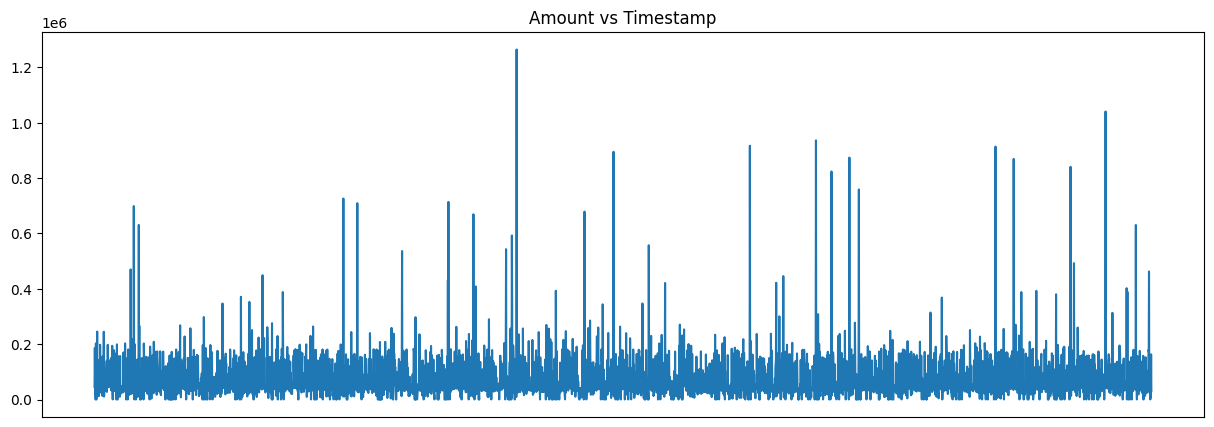

In [12]:
# AMount before log transform

plt.figure(figsize=(15,5))
plt.plot(CUST_91730['amount'])
plt.xticks([])
plt.title('Amount vs Timestamp')
plt.show()

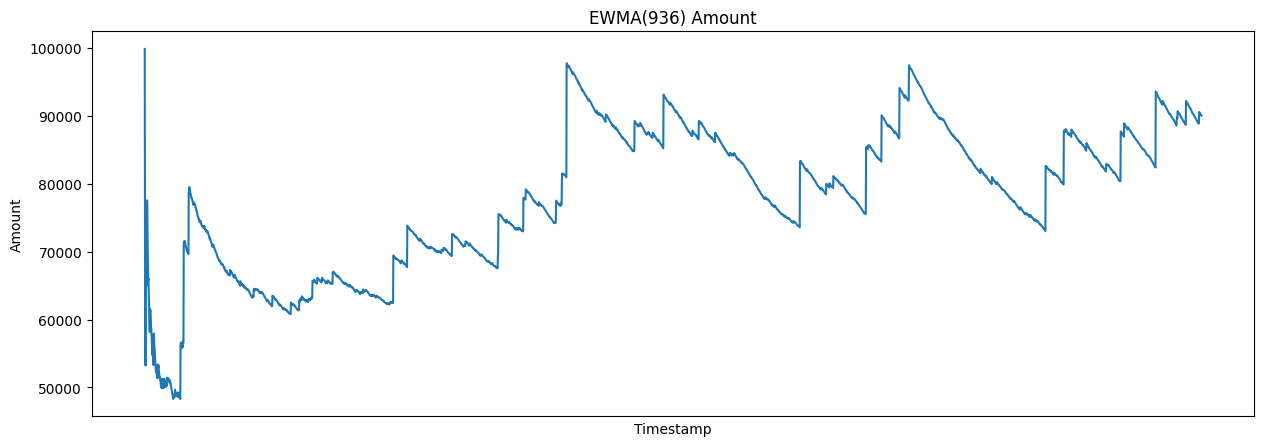

In [13]:
# EWMA before log transform

rolling_average= CUST_91730['amount'].ewm(span= window, adjust= False, ignore_na= True).std()
plt.figure(figsize=(15,5))
plt.plot(rolling_average)
plt.xticks([],rotation= 90)
plt.xlabel('Timestamp')
plt.ylabel('Amount')
plt.title('EWMA(936) Amount')
plt.show()

In [14]:
# Calaculate Z-value for amount after applying log transform to achieve normal distribution

def calculate_z_stats(in_array, mu= None, std= None):
    if isinstance(in_array, (list, np.ndarray)):
        in_array= np.array(in_array)
        mu = np.mean(in_array)
        std= stats.tstd(in_array, ddof= 0) 
        z_values= np.round(stats.zscore(in_array), 3)
        
    else:
        z_values= (in_array-mu)/std
        z_values= np.round(z_values,3)

    return z_values, mu, std

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


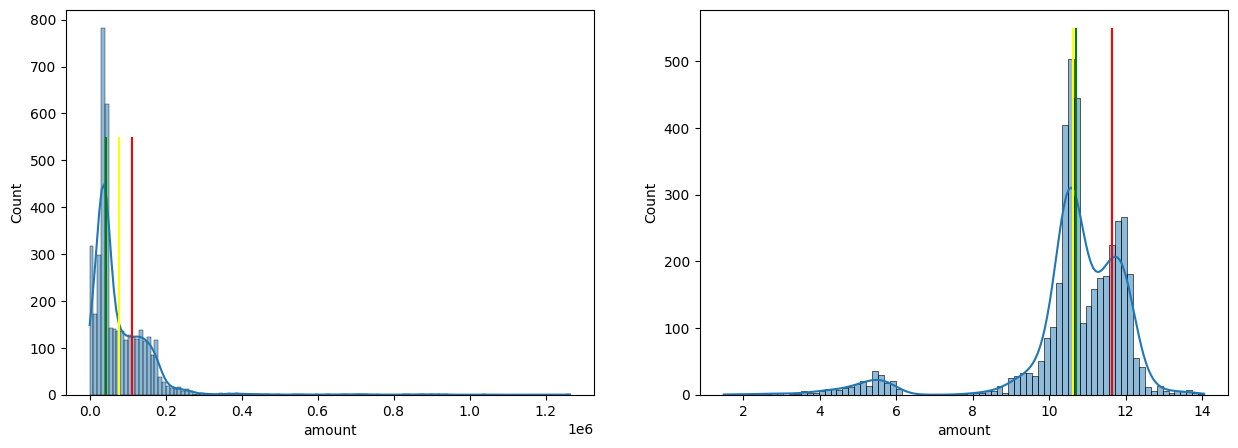

In [15]:
# Check the diff in stats for amount after transformation
fig, axs= plt.subplots(1,2, figsize= (15,5))

sns.histplot(CUST_91730['amount'], kde= True, ax= axs[0])
mean = CUST_91730['amount'].mean()
median = CUST_91730['amount'].median()
percentile90th = CUST_91730['amount'].quantile(0.75)
axs[0].vlines([mean, median, percentile90th], ymin= 0, ymax= 550, color= ['yellow', 'green', 'red'])

CUST_91730['amount'] = np.log(CUST_91730['amount'])

sns.histplot(CUST_91730['amount'], kde= True, ax= axs[1])
mean = CUST_91730['amount'].mean()
median = CUST_91730['amount'].median()
percentile90th = CUST_91730['amount'].quantile(0.75)
axs[1].vlines([mean, median, percentile90th], ymin= 0, ymax= 550, color= ['yellow', 'green', 'red'])
plt.show()

In [16]:
# # Calculate z-value
# CUST_91730['amount_z_value'], mu, std = calculate_z_stats(CUST_91730['amount'].values)

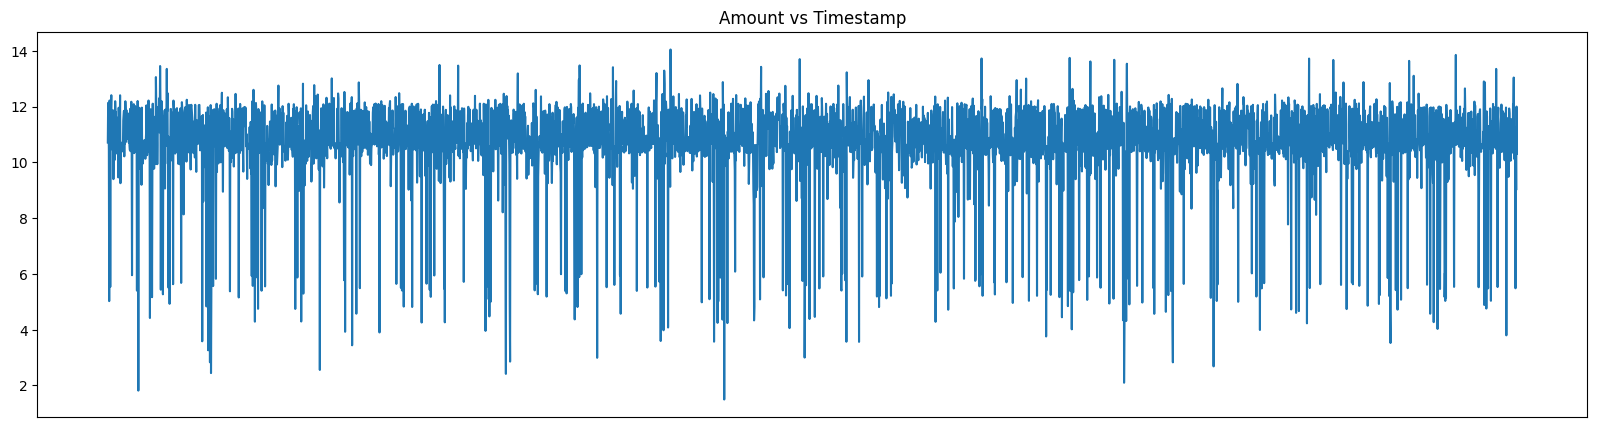

In [17]:
# AMount after log transform, before smoothening

plt.figure(figsize=(20,5))
plt.plot(CUST_91730['amount'])
plt.xticks([])
plt.title('Amount vs Timestamp')
plt.show()

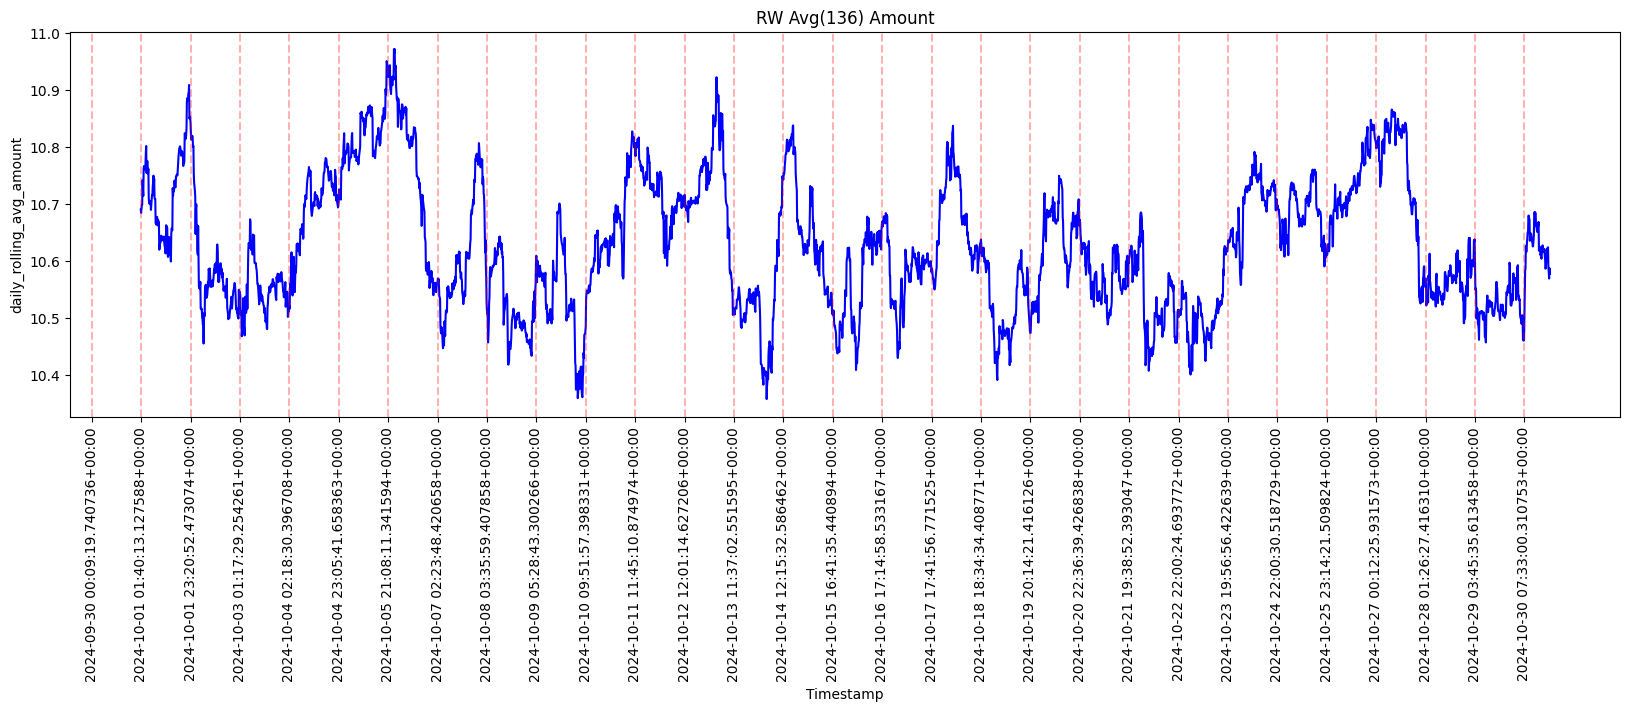

In [18]:
# SMA after log transform

CUST_91730['daily_rolling_avg_amount']= CUST_91730['amount'].rolling(136).mean()
plt.figure(figsize=(20,5))
plt.plot(CUST_91730['daily_rolling_avg_amount'],c= 'blue')
plt.xticks(ticks= [x for x in range(0,len(CUST_91730), 136)],rotation= 90)
plt.xlabel('Timestamp')
plt.ylabel('daily_rolling_avg_amount')
plt.title('RW Avg(136) Amount')
for i in [x for x in range(0,len(CUST_91730), 136)]:
    plt.axvline(CUST_91730.index[i], color='red',alpha= 0.3, linestyle= '--')
plt.show()

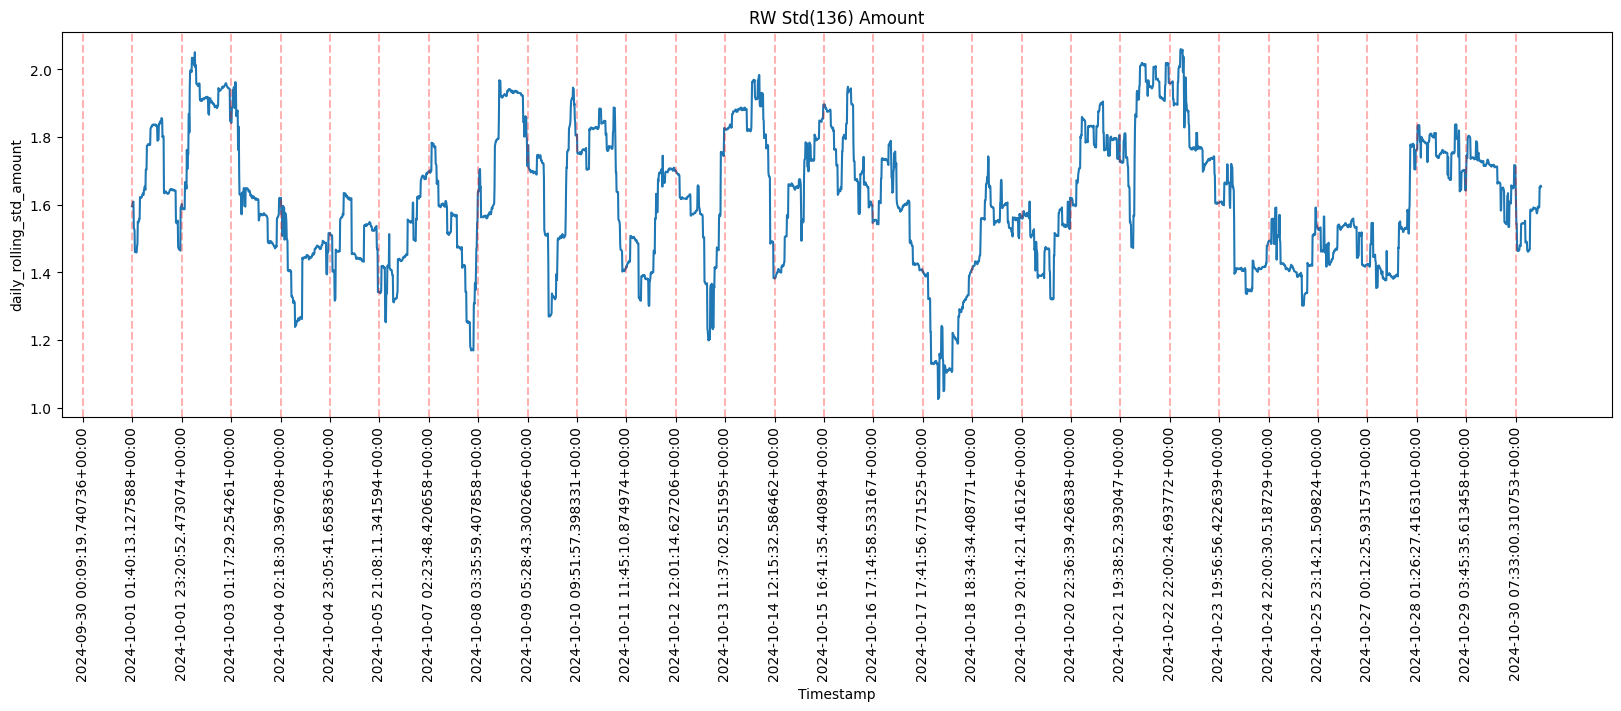

In [19]:
# SMSD after log transform

CUST_91730['daily_rolling_std_amount']= CUST_91730['amount'].rolling(136).std()
plt.figure(figsize=(20,5))
plt.plot(CUST_91730['daily_rolling_std_amount'])
plt.xticks(ticks= [x for x in range(0,len(CUST_91730), 136)],rotation= 90)
plt.xlabel('Timestamp')
plt.ylabel('daily_rolling_std_amount')
plt.title('RW Std(136) Amount')
for i in [x for x in range(0,len(CUST_91730), 136)]:
    plt.axvline(CUST_91730.index[i], color='red',alpha= 0.3, linestyle= '--')

plt.show()

    We can caclulate daily (136 transactions daily) rolling mean & std of amount and if the current value std > 1, it might be indication for suspicious expense.

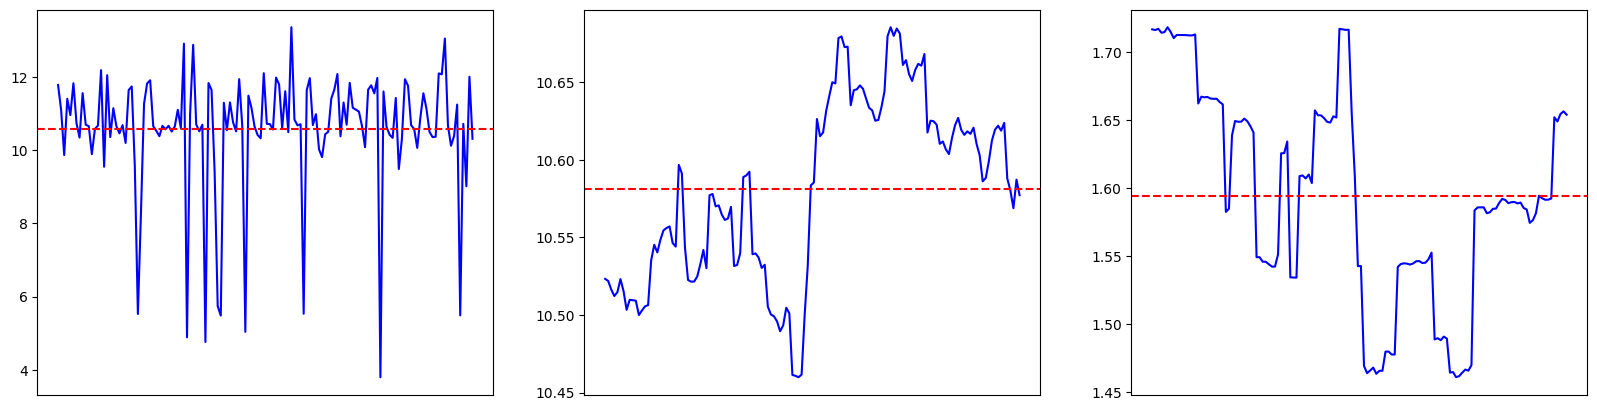

In [20]:
fig, ax= plt.subplots(1,3, figsize= (20,5), sharex= True)
ax[0].plot(CUST_91730[-136:]['amount'], c='blue')
ax[1].plot(CUST_91730[-136:]['daily_rolling_avg_amount'], c='blue')
ax[2].plot(CUST_91730[-136:]['daily_rolling_std_amount'], c= 'blue')
ax[0].axhline(CUST_91730[-136:]['amount'].mean(), linestyle= '--', color= 'red')
ax[1].axhline(CUST_91730[-136:]['daily_rolling_avg_amount'].mean(), linestyle= '--', color= 'red')
ax[2].axhline(CUST_91730[-136:]['daily_rolling_std_amount'].mean(), linestyle= '--', color= 'red')
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
plt.show()

In [21]:
CUST_91730[-10:][['amount','daily_rolling_avg_amount', 'daily_rolling_std_amount']]

,amount,daily_rolling_avg_amount,daily_rolling_std_amount
timestamp,,,
2024-10-30 20:02:40.662783+00:00,13.044532,10.612521,1.594603
2024-10-30 22:09:04.350647+00:00,10.671970,10.619445,1.592787
2024-10-30 22:31:01.781767+00:00,10.117736,10.622069,1.591656
2024-10-30 22:53:23.351714+00:00,10.382938,10.618881,1.591698
2024-10-30 22:57:42.414019+00:00,11.242166,10.623872,1.592587
2024-10-30 23:19:29.399558+00:00,5.484718,10.588044,1.652316
2024-10-30 23:23:22.695711+00:00,10.714526,10.580311,1.649220
2024-10-30 23:33:29.742633+00:00,9.009841,10.568901,1.654709
2024-10-30 23:46:40.432586+00:00,12.002006,10.587274,1.656661


In [22]:
(12.002006-CUST_91730[-138:-2]['daily_rolling_avg_amount'].mean())/CUST_91730[-138:-2]['daily_rolling_std_amount'].mean()

0.8916095235261035

In [23]:
(12.502006-CUST_91730[-138:-2]['daily_rolling_avg_amount'].mean())/CUST_91730[-138:-2]['daily_rolling_std_amount'].mean()

1.2050840902617044

    We calculate the z-score of the current value using the rolling mean and std of past days (past 24hrs) transaction and based on that if z>1 we can flag it as TP.
    
    z=  (12.002006-10.568901)/1.654709 => 0.8660767542812661
    
    Eg. here the 2nd last transaction, the z-score is <1 but if the amount is 12.502006, 
    the z value= (12.502006-10.568901)/1.654709 => 1.1682446883409707, marking it as TP case.

In [24]:
# # t-test for comparing current month stats with previous month stats
# def calculate_tstat(observations ,pop_mean):
#     t_stat, p_value= stats.ttest_1samp(observations ,pop_mean)
#     print(f't_stat: {t_stat:.3f}, p_value: {p_value:.3f}')
    
#     if p_value < 0.05 and current_month_mean > historic_mean:
#         print('Possiblity of impulsive expenditure')
    
#     else:
#         print('Normal behaviour, not impulsive expense')

In [25]:
CUST_91730['binned_hour']= pd.cut(CUST_91730['transaction_hour'], bins= [x for x in range(0,27,3)], labels= [0, 1,2,3,4,5,6,7], include_lowest= True)
CUST_91730['binned_hour']= CUST_91730['binned_hour'].astype(np.int32)
CUST_91730['week']= CUST_91730['week'].astype(np.int32)

In [26]:
CUST_91730['timestamp_lag'] = CUST_91730['timestamp'].shift(1)
CUST_91730['time_diff'] = CUST_91730['timestamp']-CUST_91730['timestamp_lag']
CUST_91730['time_diff'] = CUST_91730['time_diff'].apply(lambda x: x.total_seconds())
# CUST_91730.dropna(inplace=True)

In [27]:
velo_df= CUST_91730[(CUST_91730['week'] >= 29)].groupby(['day','binned_hour'], as_index= False).agg(avg_amount=('amount', 'mean'), avg_time_diff= ('time_diff', 'mean'))
velo_df[['day', 'binned_hour']]=velo_df[['day', 'binned_hour']].astype('int32')
velo_df

,day,binned_hour,avg_amount,avg_time_diff
0,1,0,11.294589,767.994674
1,1,1,10.535310,502.205019
2,1,2,10.193776,648.697802
3,1,3,11.113697,492.062783
4,1,4,10.669603,794.681542
...,...,...,...,...
235,30,3,10.979262,791.894816
236,30,4,10.688968,629.964427
237,30,5,10.481283,511.291682
238,30,6,10.892737,754.086013


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='avg_time_diff', ylabel='Count'>

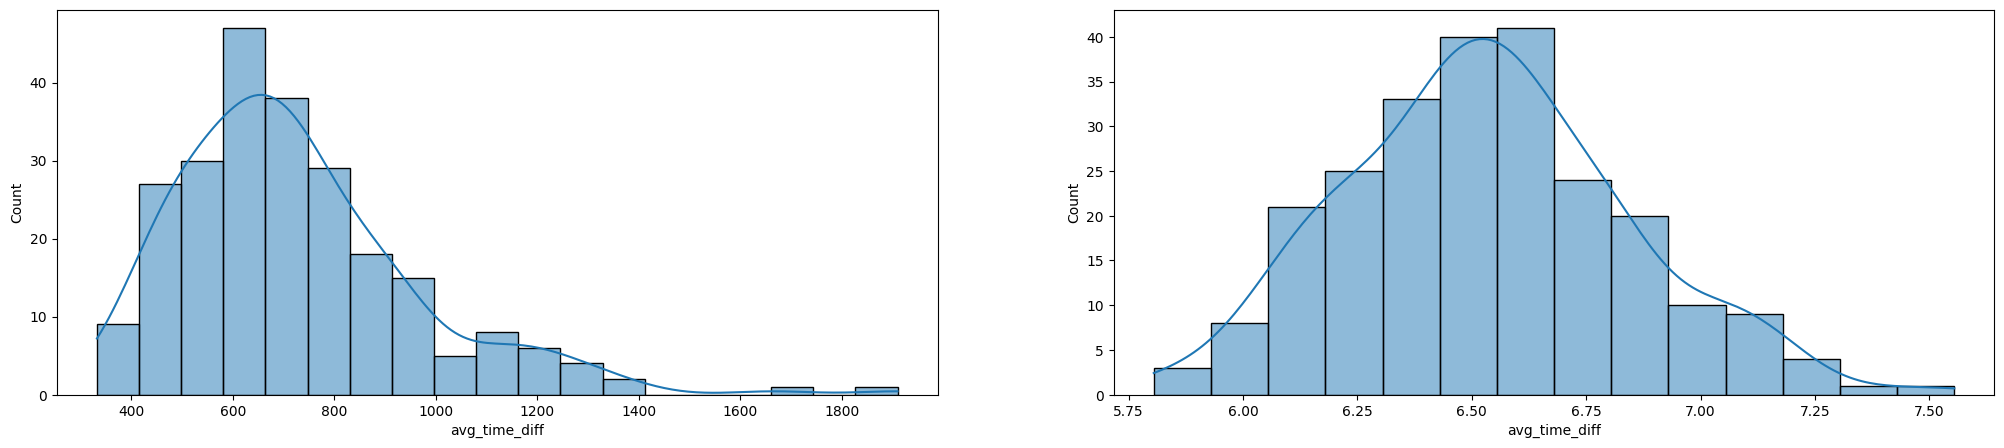

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(25,5))
sns.histplot(velo_df['avg_time_diff'], kde= True, ax= axs[0])
sns.histplot(np.log(velo_df['avg_time_diff']), kde= True, ax= axs[1])

In [29]:
print('Skewness', stats.skew(velo_df['avg_time_diff']))
print('Kurtosis', stats.kurtosis(velo_df['avg_time_diff'], fisher= False)) #fisher = True: The fisher’s definition will be used (normal 0.0).

Skewness 1.326380282066214
Kurtosis 5.886069866136777


    Positively skewed (skewness > 0)-> more weight in the left tail of the distribution.
    Leptokurtic (kurtosis > 3)-> it signifies that it tries to produce more outliers rather than the normal distribution.

<Axes: ylabel='avg_amount'>

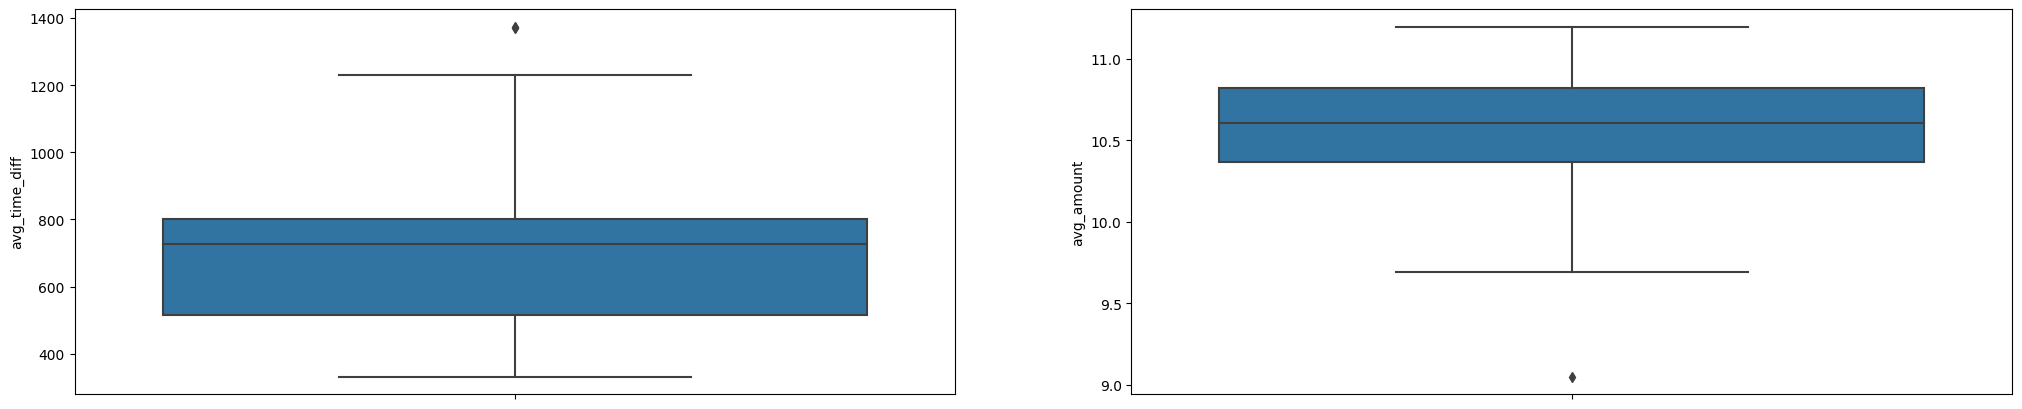

In [30]:
fig, axs= plt.subplots(1,2, figsize=(25,5))
sns.boxplot(data=velo_df.query('binned_hour == 7'), y= 'avg_time_diff', ax= axs[0])
sns.boxplot(data=velo_df.query('binned_hour == 7'), y= 'avg_amount', ax= axs[1])

In [31]:
z= (10 - velo_df['avg_amount'].mean())/velo_df['avg_amount'].std()
z

-1.3180607345940962

In [32]:
z= (1200- velo_df['avg_time_diff'].mean())/velo_df['avg_time_diff'].std()
z

1.9981149920169432

    We can see that avg_time_diff between transactions and avg_transaction_amount over past few weeks during a particular hour can be used as an indicator for 
    unusual transaction. We can take anything below a certain z-value as outlier and flag the transaction (high frequency low volume transaction during that hour).

In [33]:
from datetime import datetime

def calculate_z_value(value, mean, std, attribute):
    z = (value - mean) / std
    stats=  f'Mean for {attribute}: {mean},\n Std for {attribute}: {std}'
    
    return (z, stats)

def flag_freq_volume(data, timestamp, hour_bin, amount):
    velo_df= data.groupby(['day','binned_hour'], as_index= False).agg(avg_amount=('amount', 'mean'), avg_time_diff= ('time_diff', 'mean'))
    velo_df[['day', 'binned_hour']]= velo_df[['day', 'binned_hour']].astype('int32')

    time_delta= timestamp - data['timestamp'][-1]
    time_delta= time_delta.total_seconds()

    time_avg= velo_df['avg_time_diff'].mean()
    time_std= velo_df['avg_time_diff'].std()
    Z_time, _= calculate_z_value(time_delta, time_avg, time_std, 'Time_delta')

    amount_avg= velo_df['avg_amount'].mean()
    amount_std= velo_df['avg_amount'].std()
    Z_amount, _= calculate_z_value(amount, amount_avg, amount_std, 'Time_delta_Amount')

    freq_violation = Z_time < -2 # high frequency
    amount_violation = Z_amount < -3 # low amount

    freq_vol_stats= f'Avg Amount during binned hour {hour_bin}: {amount_avg},\n\
            Avg seconds between transactions during binned hour {hour_bin}: {time_avg}'

    return ((freq_violation & amount_violation), freq_vol_stats)
    

def calculate_rolling_stats(data, window):
    rolling_mean= data.rolling(window, min_periods= 1).mean()
    rolling_std= data.rolling(window, min_periods = 1).std()
    avg= np.nanmean(rolling_mean)
    std= rolling_std[-1]
    
    return avg, std
    

def calculate_stats(json_input, data, window= 136):
    total_amount= np.float64(json_input.get('amount', 0))

    try:
        timestamp= json_input.get('timestamp', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        timestamp= pd.to_datetime(timestamp)
        
        week= timestamp.week
        month= timestamp.month
        week_day= timestamp.day_of_week
        hour= timestamp.hour
        hour_bin= hour//3
    
    except Exception as e:
        raise e
    
    merchant= json_input.get('merchant', 'Unknown').lower()
    merchant_cat= json_input.get('merchant_category', 'Unknown').lower()

    # Rolling window stats for last 24 hours (136 previous data points), using week to get enough data
    prior_week= week
    week_data= pd.DataFrame()
    while week_data.shape[0] < window:
        week_data= data[data['week'] >= prior_week]
        prior_week= prior_week-1

    rolling_mean, rolling_std= calculate_rolling_stats(week_data['amount'], window= window)

    # Hourly stats since past few weeks
    bin_hour_mean= data[(data['binned_hour'] == hour_bin) & (data['week'] >= prior_week)]['amount'].mean()
    bin_hour_std= data[(data['binned_hour'] == hour_bin) & (data['week'] >= prior_week)]['amount'].std()

    # Category Level stats
    merchant_cat_mean= data[(data['merchant_category'].str.lower() == merchant_cat) & (data['week'] >= prior_week)]['amount'].mean()
    merchant_cat_std= data[(data['merchant_category'].str.lower() == merchant_cat) & (data['week'] >= prior_week)]['amount'].std()

    # Merchant Level stats
    merchant_mean= data[(data['merchant'].str.lower() == merchant) & (data['week'] >= prior_week)]['amount'].mean()
    merchant_std= data[(data['merchant'].str.lower() == merchant) & (data['week'] >= prior_week)]['amount'].std()

    # Frequency Volume stats
    hig_freq_low_volume_flag, hig_freq_low_volume_stats = flag_freq_volume(week_data, timestamp, hour_bin, total_amount)

    z_rolling_amount = calculate_z_value(total_amount, rolling_mean, rolling_std, 'Z_Rolling_Amount')
    z_bin_hr_amount = calculate_z_value(total_amount, bin_hour_mean, bin_hour_std, 'Z_Bin_hour_Amount')
    z_merchant_cat_amount = calculate_z_value(total_amount, merchant_cat_mean, merchant_cat_std, 'Z_Merchant_Cat_Amount')
    z_merchant_amount = calculate_z_value(total_amount, merchant_mean, merchant_std, 'Z_Merchant_Amount')

    return ((z_rolling_amount, z_bin_hr_amount, z_merchant_cat_amount, z_merchant_amount), (hig_freq_low_volume_flag, hig_freq_low_volume_stats))    

In [34]:
CUST_91730.tail(10)

,transaction_id,customer_id,timestamp,merchant_category,merchant_type,merchant,amount,currency,channel,transaction_hour,weekend_transaction,month,week,day,week_day,daily_rolling_avg_amount,daily_rolling_std_amount,binned_hour,timestamp_lag,time_diff
timestamp,,,,,,,,,,,,,,,,,,,,
2024-10-30 20:02:40.662783+00:00,TX_964c33db,CUST_91730,2024-10-30 20:02:40.662783+00:00,Travel,airlines,United Airlines,13.044532,INR,offline,20,False,10,43,30,2,10.612521,1.594603,6,2024-10-30 19:24:54.474967+00:00,2266.187816
2024-10-30 22:09:04.350647+00:00,TX_86a6b0f4,CUST_91730,2024-10-30 22:09:04.350647+00:00,Healthcare,medical,Local Hospital,10.671970,INR,online,22,False,10,43,30,2,10.619445,1.592787,7,2024-10-30 20:02:40.662783+00:00,7583.687864
2024-10-30 22:31:01.781767+00:00,TX_0d18b76e,CUST_91730,2024-10-30 22:31:01.781767+00:00,Grocery,physical,Trader Joe's,10.117736,INR,online,22,False,10,43,30,2,10.622069,1.591656,7,2024-10-30 22:09:04.350647+00:00,1317.431120
2024-10-30 22:53:23.351714+00:00,TX_ff7ee788,CUST_91730,2024-10-30 22:53:23.351714+00:00,Grocery,physical,Publix,10.382938,INR,online,22,False,10,43,30,2,10.618881,1.591698,7,2024-10-30 22:31:01.781767+00:00,1341.569947
2024-10-30 22:57:42.414019+00:00,TX_a6c89446,CUST_91730,2024-10-30 22:57:42.414019+00:00,Retail,online,Newegg,11.242166,INR,online,22,False,10,43,30,2,10.623872,1.592587,7,2024-10-30 22:53:23.351714+00:00,259.062305
2024-10-30 23:19:29.399558+00:00,TX_cda65552,CUST_91730,2024-10-30 23:19:29.399558+00:00,Entertainment,streaming,Amazon Prime,5.484718,INR,online,23,False,10,43,30,2,10.588044,1.652316,7,2024-10-30 22:57:42.414019+00:00,1306.985539
2024-10-30 23:23:22.695711+00:00,TX_6344ce63,CUST_91730,2024-10-30 23:23:22.695711+00:00,Retail,physical,Walmart,10.714526,INR,online,23,False,10,43,30,2,10.580311,1.649220,7,2024-10-30 23:19:29.399558+00:00,233.296153
2024-10-30 23:33:29.742633+00:00,TX_aa4d2acc,CUST_91730,2024-10-30 23:33:29.742633+00:00,Entertainment,streaming,Hulu,9.009841,INR,online,23,False,10,43,30,2,10.568901,1.654709,7,2024-10-30 23:23:22.695711+00:00,607.046922
2024-10-30 23:46:40.432586+00:00,TX_b6988ebd,CUST_91730,2024-10-30 23:46:40.432586+00:00,Gas,major,Exxon,12.002006,INR,online,23,False,10,43,30,2,10.587274,1.656661,7,2024-10-30 23:33:29.742633+00:00,790.689953


In [35]:
in_file= {
    'merchant': 'Amazon Prime',
    'merchant_category': 'Entertainment',
    'amount': 5.484718,
    'timestamp': '2024-10-30 23:19:29.399558+00:00'
}

In [36]:
stats= calculate_stats(in_file, CUST_91730, 136)
stats

/tmp/ipykernel_13/3752406740.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std= rolling_std[-1]
/tmp/ipykernel_13/3752406740.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  time_delta= timestamp - data['timestamp'][-1]


(((-3.0920248622782904,
   'Mean for Z_Rolling_Amount: 10.599509035134323,\n Std for Z_Rolling_Amount: 1.6541881980100257'),
  (-2.8618594407292117,
   'Mean for Z_Bin_hour_Amount: 10.396998177777421,\n Std for Z_Bin_hour_Amount: 1.7164645152963052'),
  (-3.5068472672644124,
   'Mean for Z_Merchant_Cat_Amount: 10.404462925824715,\n Std for Z_Merchant_Cat_Amount: 1.402896833218078'),
  (-1.7972566943409716,
   'Mean for Z_Merchant_Amount: 9.342530107482549,\n Std for Z_Merchant_Amount: 2.146500341119694')),
 (True,
  'Avg Amount during binned hour 7: 10.617405696153867,\n            Avg seconds between transactions during binned hour 7: 803.1177611038893'))

In [37]:
CUST_91730[(CUST_91730['merchant']=='Exxon')]['amount'].max()

12.181043697360332

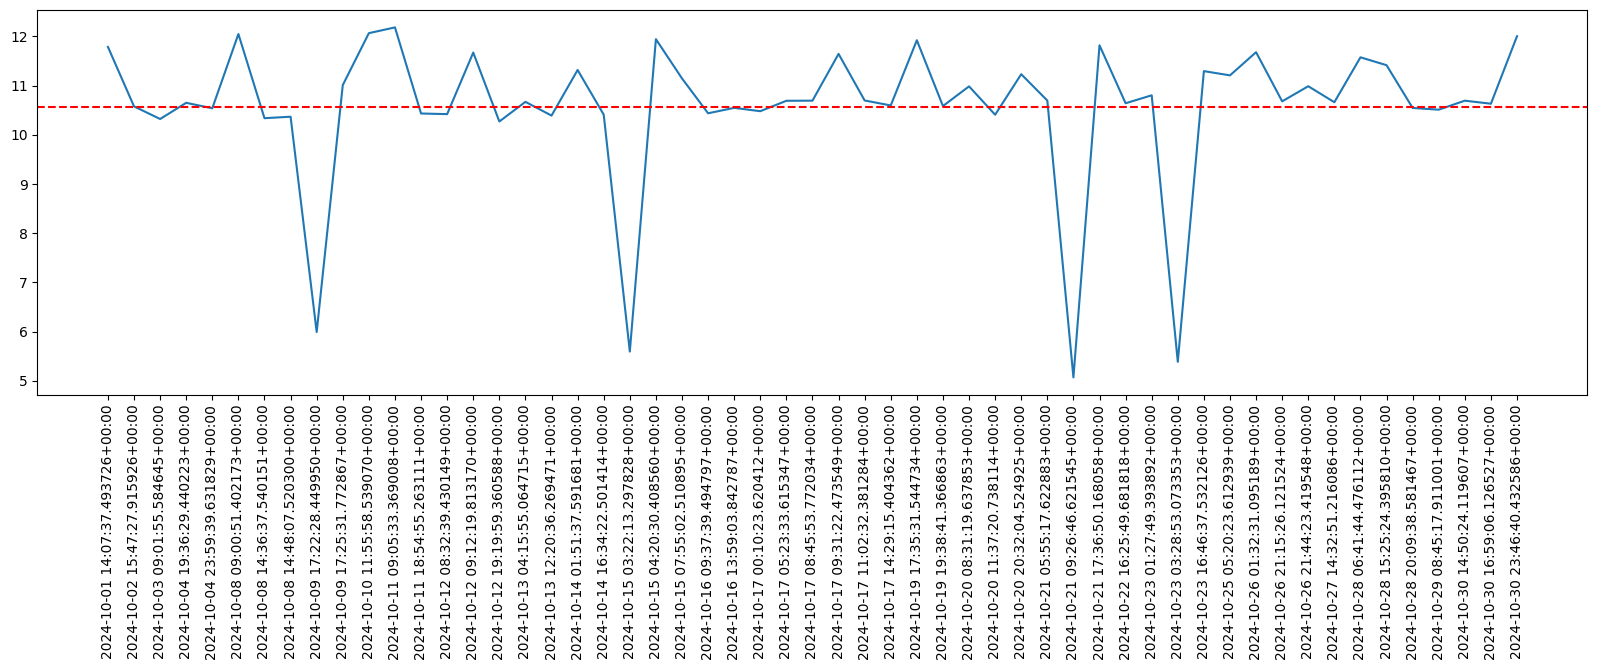

In [38]:
plt.figure(figsize= (20,5))
plt.plot(CUST_91730[(CUST_91730['merchant']=='Exxon')]['amount'])
plt.axhline(CUST_91730[(CUST_91730['merchant']=='Exxon')]['amount'].mean(), color='red', linestyle= '--')
plt.xticks(rotation=90)
plt.show()